### Импорт библиотек и данных

In [411]:
# работа с данными
import numpy as np 
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# работа с признаками:
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

#инструменты для балансировония выборки данных по целевому признаку
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


#DATA_DIR = '/kaggle/input/sf-scoring/'
DATA_DIR = './data/'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



### Функции

In [412]:
# ф-я принимает серию возвращает кортеж :
# [0]-25% перцентиль серии
# [1]-75% перцентиль серии
# [2]-IQR
# [3]-нижняя граница выбросов
# [4]-верхняя граница выбросов

def get_bounds(ser):
    perc25 = ser.quantile(0.25)
    perc75 = ser.quantile(0.75)
    IQR = perc75-perc25

    return (perc25, perc75, IQR, perc25-1.5*IQR, perc75+1.5*IQR)

### Поверхностный осмотр данных

In [413]:
sample_submission.shape

(36349, 2)

In [414]:
df_test.shape

(36349, 18)

In [415]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [416]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [417]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [418]:
sample_submission.head(5)

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0


In [419]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


###### Соединение train и test датасетов

In [420]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

###### Education содержит около 300 пропусков (менее 0.5%) поэтому заполним пропуски наиболее часто встречаемым значением

<AxesSubplot:>

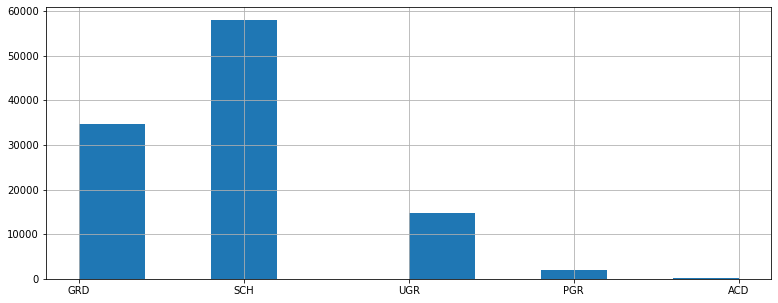

In [421]:
data.education.hist()

In [422]:
education = data.education.fillna('SCH')
data['education'] = education

In [423]:
data.nunique(dropna=False)

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

###### Для дальнейшего удобства разделим признаки разных типов

In [424]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

### EDA

###### Рассмотрим распределение целевого признака

<AxesSubplot:>

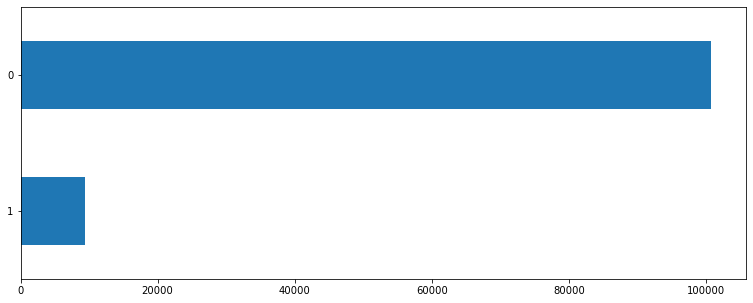

In [425]:
data['default'].value_counts(ascending=True).plot(kind='barh')

###### как видим, дефолты по кредиту допускает малая часть клиентов

###### Рассмотрим распределение числовых признаков

C:\Users\LocalAdministrator\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


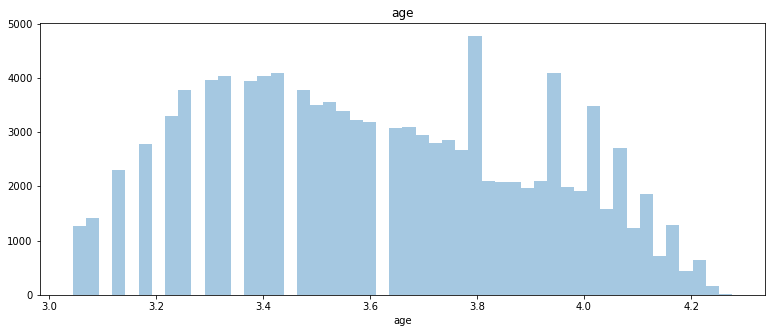

C:\Users\LocalAdministrator\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


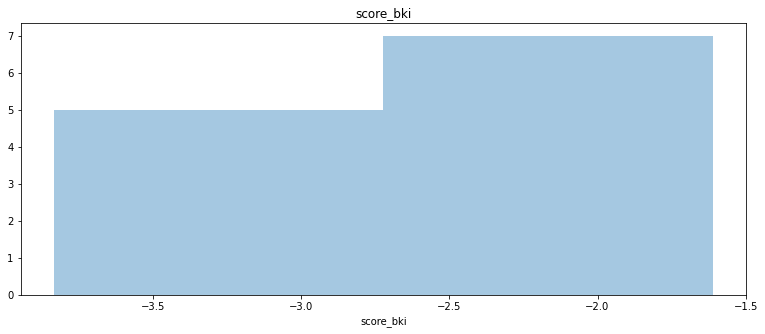

C:\Users\LocalAdministrator\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


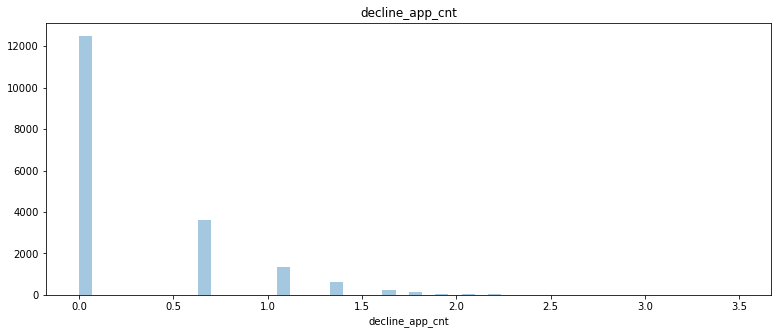

C:\Users\LocalAdministrator\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


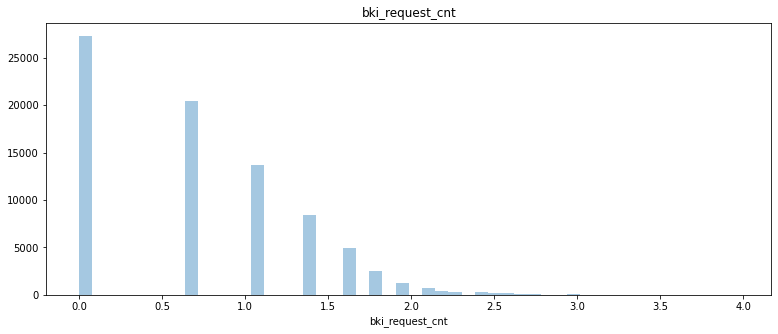

C:\Users\LocalAdministrator\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


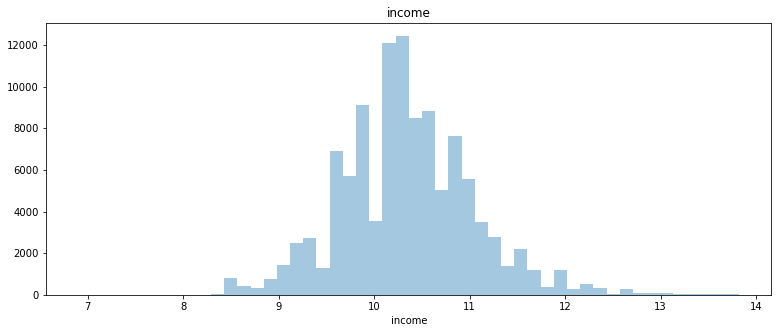

In [426]:
# большинство распределений имеют "Большой правый хвост", поэтому берем логарифм
for i in num_cols:
    plt.figure()
    sns.distplot(np.log(data[i][data[i]>0].dropna()), kde=False, rug=False)
    plt.title(i)
    plt.show()

###### Рассмотрим распределение возраста заемщиков 2 групп: допустивших и не допустивших дефолт

<AxesSubplot:xlabel='default', ylabel='age'>

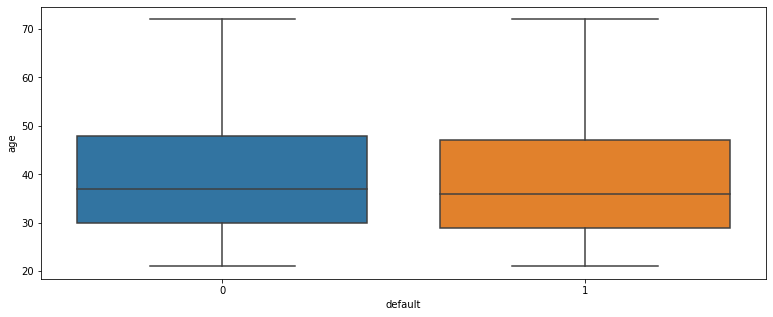

In [427]:
sns.boxplot(x = 'default', y ='age', data = data)

###### видим примерно одинаковое распределение возраста среди заемщиков допустивших и не допустивших дефолт

###### Рассмотрим распределение по кол-ву отказов и долю допустивших и не допустивших дефолт в зависимости от кол-ва отказов

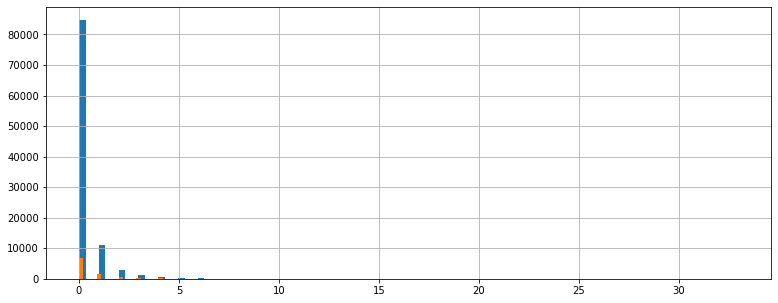

In [428]:
for x in (data['default'].value_counts()).index:
    data.decline_app_cnt[data['default'] == x].hist(bins =100)
plt.show()

###### Такой график мало показателен, построим график отношения кол-ва дефолтов к кол-ву не дефолтов в каждой группе по кол-ву отказов

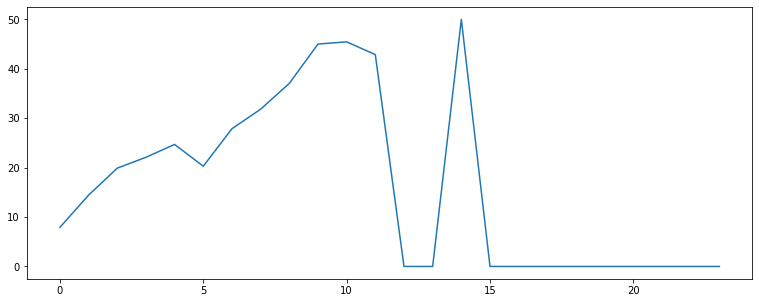

In [429]:
vals1 = []

for x in (data.decline_app_cnt.value_counts()).index:
    defaults = len(data[(data.decline_app_cnt == x)&(data.default ==1)])
    no_defaults = len(data[(data.decline_app_cnt == x)&(data.default ==0)])
    vals1.append(0 if no_defaults == 0 else round(100*(defaults/no_defaults),2))
plt.plot(vals1)

###### Видим, что с ростом кол-ва отказов растет и доля дефолтных клиентов, вплоть до 45% с 8 отказов, причем до 11 отказов зависимость похожа на линейную, поэтому для обучения модели имеет смысл отбросить примеры с более чем 10 отказов

In [430]:
data.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

###### Построим аналогичный график для bki_request_cnt

In [431]:
# получим границы выбросов по bki_request_cnt
get_bounds(data['bki_request_cnt'])

(0.0, 3.0, 3.0, -4.5, 7.5)

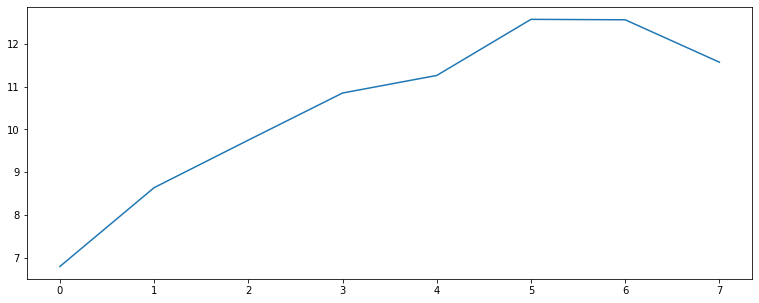

In [432]:
vals2 = []

# Сразу отбросим выбросы, т.к. если модель начнет учитывать случаи по 20 и 30 запросов - переобучится
for x in (data[data['bki_request_cnt']<8].bki_request_cnt.value_counts()).index:
    defaults = len(data[(data['bki_request_cnt'] == x)&(data.default ==1)])
    no_defaults = len(data[(data['bki_request_cnt'] == x)&(data.default ==0)])
    vals2.append(0 if no_defaults == 0 else round(100*(defaults/no_defaults),2))
plt.plot(vals2)

###### Видим, что с ростом кол-ва отказов растет и доля дефолтных клиентов, вплоть до 12% с 6 запросов

###### Рассмотрим кол-во дефолтников в разных группах по доходам

In [433]:
# получим границы выбросов по bki_request_cnt
get_bounds(data['income'])

(20000.0, 48000.0, 28000.0, -22000.0, 90000.0)

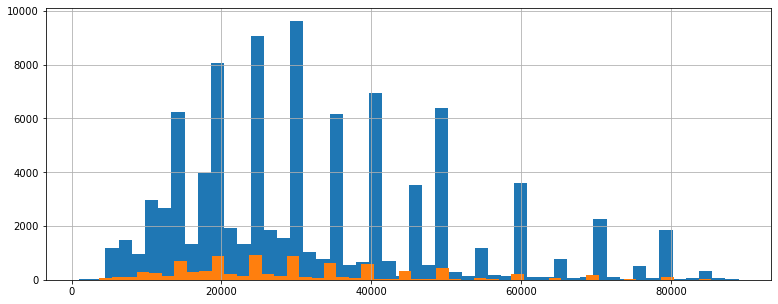

In [434]:
for x in (data['default'].value_counts()).index:
    data[data.income<90000].income[data['default'] == x].hist(bins =50)
plt.show()

<AxesSubplot:xlabel='default', ylabel='income'>

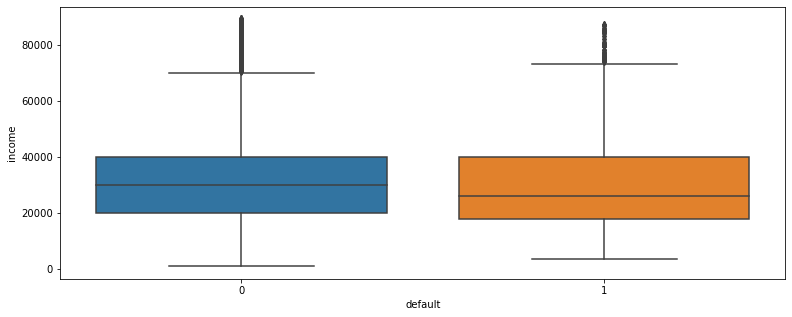

In [435]:
sns.boxplot(x = 'default', y ='income', data = data[data.income<90000])

###### Среди клиентов с большим доходом, дефолтники встречаются реже

###### Рассмотрим влияние признака score_bki 

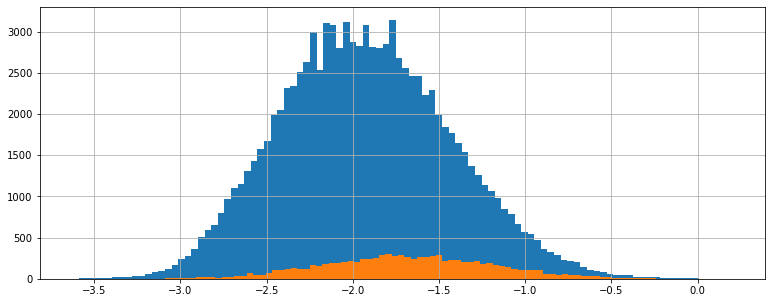

In [436]:
for x in (data['default'].value_counts()).index:
    data.score_bki[data['default'] == x].hist(bins =100)
plt.show()

###### У дефолтников score_bki в среднем ближе к 0

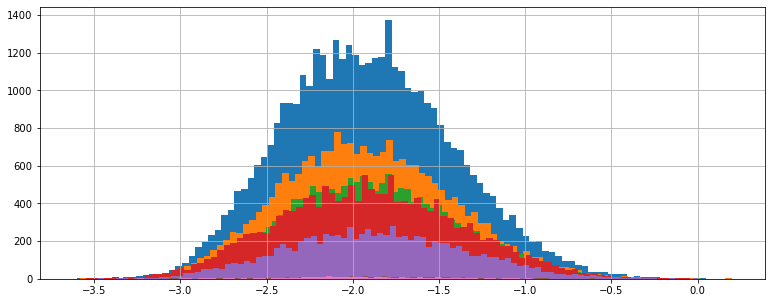

In [437]:
for x in (data['region_rating'].value_counts().index):
    data['score_bki'][(data['region_rating'] == x)].hist(bins =100)
plt.show()

 ###### Как видим, score_bki примерно равномерен во всех регионах

###### Но регионов с рейтингом 50% подавляющее большинство:

In [438]:
data['region_rating'].value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

###### Поэтому на этапе Feature Engineering имеет смысл ввести новый признак - кол-во примеров из региона данного рейтинга

<AxesSubplot:xlabel='default', ylabel='score_bki'>

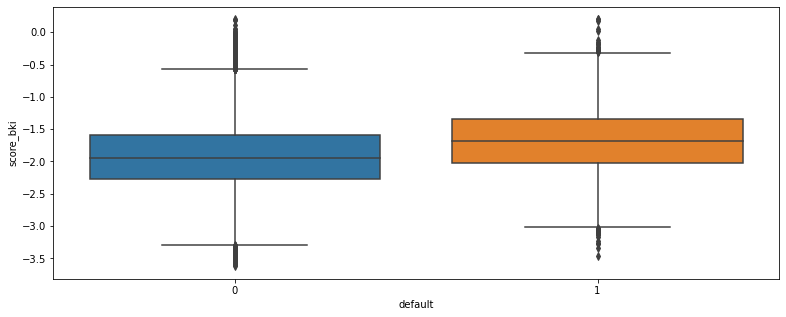

In [439]:
sns.boxplot(x = 'default', y ='score_bki', data = data)

###### Как видим, у дефолтников меньше по модулю score_bki

###### Построим карту корреляции числовых признаков

<AxesSubplot:>

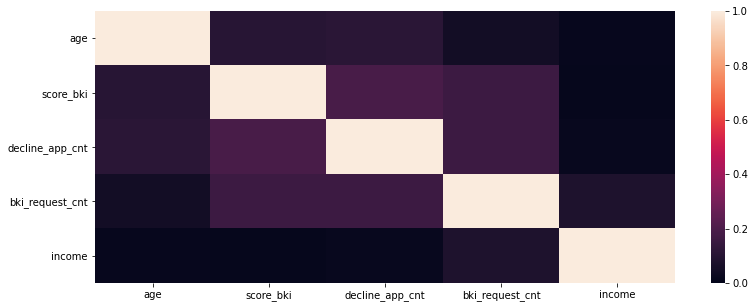

In [440]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

###### сильно скоррелированных признаков нет

<AxesSubplot:>

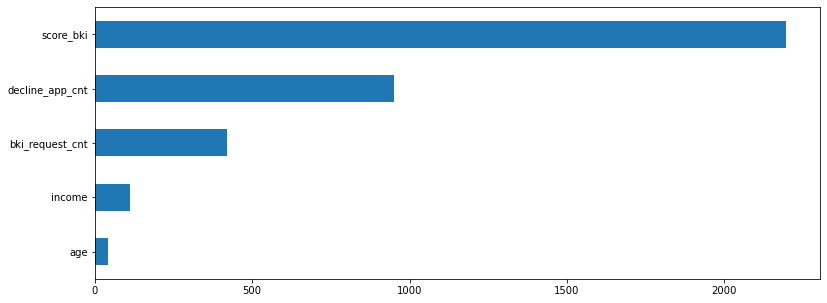

In [441]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [442]:
# кол-во символов для показа
pd.options.display.max_colwidth = 74
# выводить все столбцы
pd.set_option('display.max_columns', None)
# размер плота
plt.rcParams['figure.figsize'] = (13,5)

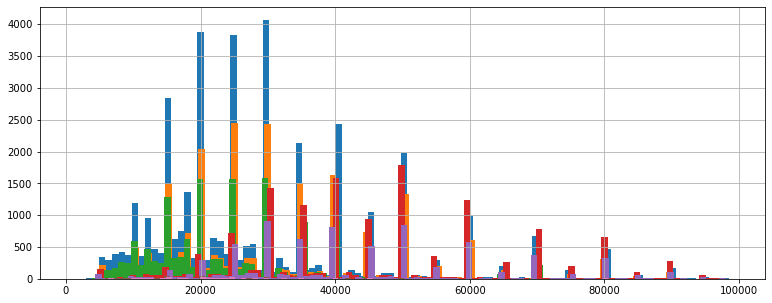

In [443]:
for x in (data['region_rating'].value_counts().index):
    data['income'][(data['region_rating'] == x)&(data['income']<100000)].hist(bins =100)
plt.show()

###### В разных регионах доходы "размазаны" примерно одинаково

In [444]:
data['region_rating'].value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

###### оценка значимости категориальных признаков

In [445]:
#Закодируем бинарные признаки
label_encoder = LabelEncoder()
for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

#Закодируем категоориальные признаки, требующие этого
data['education'] = data['education'].replace(to_replace={'SCH':1,'GRD':2,'UGR':3,'PGR':4,'ACD':5})
    
# убедимся в преобразовании    
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
26403,75851,23MAR2014,1,0,57,0,0,0,0,-2.566873,0,80,2,3,20000,1,3,1,0,0
76053,51228,28FEB2014,1,0,49,0,0,0,0,-2.371234,3,60,1,2,20000,3,3,1,1,0
66400,34761,11FEB2014,1,1,31,0,0,0,0,-2.004144,0,60,2,3,30000,1,4,0,1,0
79959,9199,16JAN2014,1,1,43,0,0,0,0,-2.129857,1,50,1,1,20000,4,1,0,1,0
86454,30340,06FEB2014,1,0,28,1,0,2,0,-2.158722,12,50,1,1,16000,4,1,0,1,0


<AxesSubplot:>

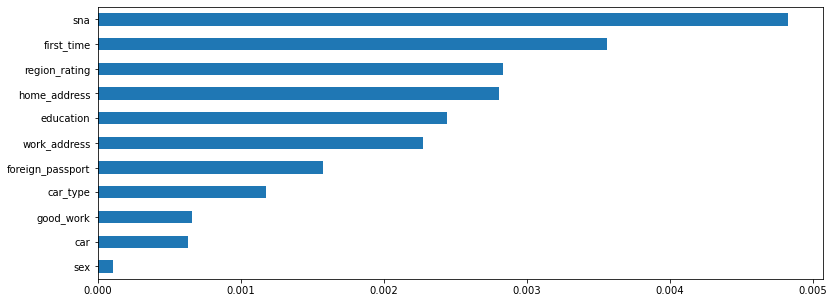

In [446]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')



###### Забавно, что хорошая работа далеко не первая в списке значимых признаков

###### Рассмотрим корреляцию категориальных признаков

<AxesSubplot:>

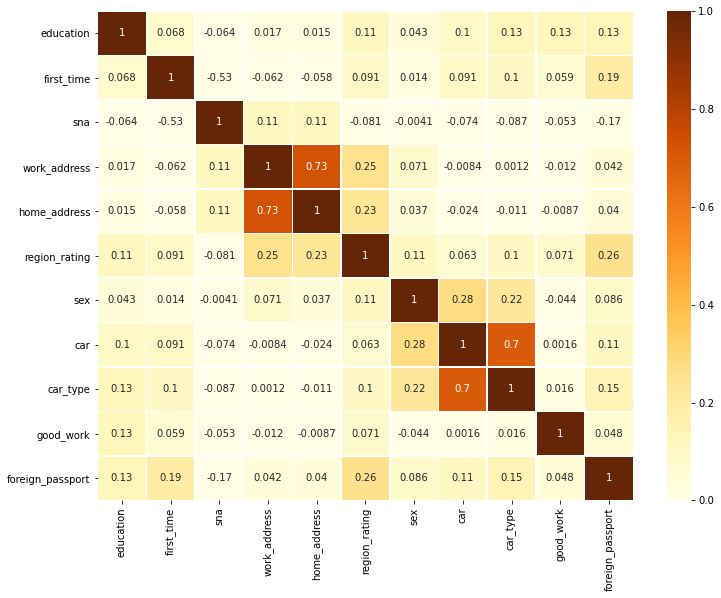

In [447]:
plt.figure(figsize=(12, 9))
sns.heatmap(data[cat_cols+bin_cols].corr(), vmin=0, vmax=1,annot=True, cmap='YlOrBr', linewidths=.5)

###### work_address сильно скоррелирована с home_address и имеет меньшую значимость, Sex, car, good_work имеют наименьшую значимость, удалим все эти признаки на этапе подготовки данных

# FE (feature egineering)

In [448]:
# Нормализуем доход относительно медианного в регионах одного рейтинга
# median_income_in_regions - это словарь, содержащий медианные income в регионах с одного рейтинга
median_income_in_regions = data.groupby(['region_rating'])['income'].median().sort_values(ascending=False).to_dict()

data['median_income_in_region'] = data['region_rating'].replace(to_replace=median_income_in_regions)
#data['income_region_norm'] = data['income']/data['median_income_in_region'] 

num_cols.append('median_income_in_region')
#num_cols.append('income_region_norm')

In [449]:
# Это вычисление медианного рейтинга по регионам и нормализация рейтинга относительно медианного в регионе. 
# получившиеся новые признаки сильно коррелируют с остальными, поэтому не включаем в модель

#median_bki_in_region = data.groupby(['region_rating'])['score_bki'].median().sort_values(ascending=False).to_dict()

#data['median_bki_in_region'] = data['region_rating'].replace(to_replace=median_bki_in_region)
#data['bki_region_norm'] = data['score_bki']/data['median_bki_in_region'] 

#num_cols.append('median_bki_in_region')
#num_cols.append('bki_region_norm')


In [450]:
# кол-во примеров в каждом типе региона (по рейтингу)
number_of_samples_in_region = data.region_rating.value_counts().to_dict()
data['number_of_samples_in_region'] = data['region_rating'].replace(to_replace=number_of_samples_in_region)
num_cols.append('number_of_samples_in_region')

In [451]:
data = pd.get_dummies(data, columns=['education'], dummy_na=True)

<AxesSubplot:>

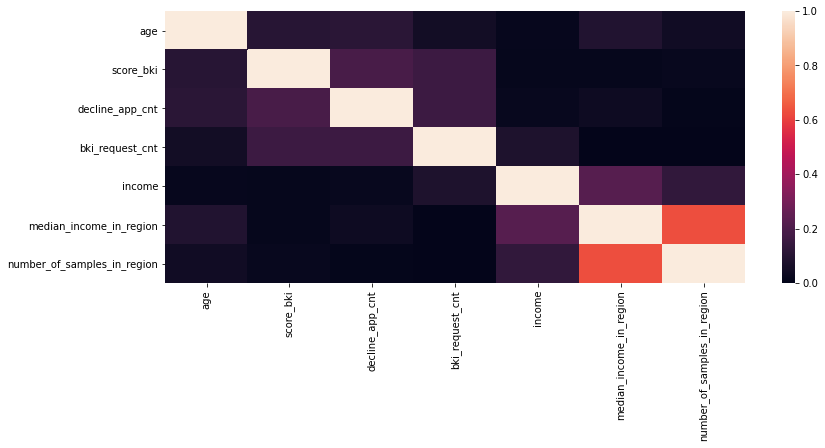

In [452]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

# Подготовка данных

###### преобразование бинарных признаков

In [453]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.sample(5)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,median_income_in_region,number_of_samples_in_region,education_1.0,education_2.0,education_3.0,education_4.0,education_5.0,education_nan
34119,56207,05MAR2014,1,48,0,0,0,0,-2.357292,0,40,2,3,26300,4,1,0,0,0,25000,17947,0,1,0,0,0,0
77974,58767,07MAR2014,1,33,1,1,1,1,-1.688146,0,50,2,3,70000,2,1,0,1,0,25000,40981,0,1,0,0,0,0
47493,21145,28JAN2014,1,45,0,0,0,0,-2.175895,0,60,2,3,40000,2,4,0,1,1,30000,23999,0,1,0,0,0,0
94313,48739,25FEB2014,0,28,1,1,0,0,-1.426378,4,50,1,1,17000,1,3,0,1,0,25000,40981,0,1,0,0,0,0
2513,57961,06MAR2014,1,37,1,1,0,0,-1.873118,2,60,1,1,45000,2,3,0,0,0,30000,23999,0,1,0,0,0,0


###### Удалим лишние признаки

In [454]:
# work_address  Sex, car, good_work 
data.drop(['client_id','app_date','sex','car','good_work', 'work_address'], axis = 1, inplace=True)
bin_cols.remove('sex')
bin_cols.remove('car')
bin_cols.remove('good_work')
cat_cols.remove('work_address')

In [455]:
data.sample(5)

,age,car_type,decline_app_cnt,score_bki,bki_request_cnt,region_rating,home_address,income,sna,first_time,foreign_passport,sample,default,median_income_in_region,number_of_samples_in_region,education_1.0,education_2.0,education_3.0,education_4.0,education_5.0,education_nan
27859,45,0,0,-2.656781,8,60,2,120000,1,3,1,0,0,30000,23999,0,0,1,0,0,0
69339,42,0,0,-2.050480,0,60,1,60000,1,3,1,1,0,30000,23999,0,0,1,0,0,0
55190,43,0,0,-2.264397,2,80,1,30000,2,1,0,1,0,48000,17170,1,0,0,0,0,0
73277,47,1,0,-2.041011,1,80,3,150000,1,1,0,1,0,48000,17170,0,1,0,0,0,0
104999,34,1,1,-1.198261,19,70,1,53000,1,3,0,1,0,43000,9304,0,1,0,0,0,0


###### Логарифмируем числовые признаки

In [456]:
data['age'] = np.log(data['age']+1)
data['income'] = np.log(data['income']+1)
data['bki_request_cnt'] = np.log(data['bki_request_cnt']+1)
data['decline_app_cnt'] = np.log(data['decline_app_cnt']+1)

###### Разделим обратно тренировочный и тестовый датасеты

In [457]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

###### В тренировочном датасете удалим выбросы

In [458]:
train_data = train_data[train_data.decline_app_cnt<11]
train_data = train_data[train_data.bki_request_cnt<8]
train_data = train_data[data.income<90000]

<ipython-input-458-1b5c25c0ff70>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_data = train_data[data.income<90000]


###### поскольку, истинное значение целевого признака у нас есть только в train_data, разделим train_data на teach (для обучения модели) и control (для промежуточной проверки модели). Также, наша выборка сильно дисбалансирована, случаев с default =0 сильно больше, поэтому необходимо применить одну из стратегий балансирования выборки по целевой переменной (Under|Over Sampling)

In [459]:
# выделяем признаки и целевую переменную
X = train_data.drop(['default'],axis=1)
y = train_data['default']

# UnderSampling (f1-score = 0.68)
#rus = RandomUnderSampler(sampling_strategy=1, random_state=42)
#X_us, y_us = rus.fit_resample(X, y)

# OverSampling (f1-score = 0.67)
rus = SMOTE(sampling_strategy=1, random_state=42)
X_us, y_us = rus.fit_resample(X, y)


#X_teach, X_control, y_teach, y_control = train_test_split(X, y, test_size=0.1, random_state=42, shuffle = True,)
X_teach, X_control, y_teach, y_control = train_test_split(X_us, y_us, test_size=0.1, random_state=42, shuffle = True,)

In [460]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 36349 to 110147
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          73799 non-null  float64
 1   car_type                     73799 non-null  int64  
 2   decline_app_cnt              73799 non-null  float64
 3   score_bki                    73799 non-null  float64
 4   bki_request_cnt              73799 non-null  float64
 5   region_rating                73799 non-null  int64  
 6   home_address                 73799 non-null  int64  
 7   income                       73799 non-null  float64
 8   sna                          73799 non-null  int64  
 9   first_time                   73799 non-null  int64  
 10  foreign_passport             73799 non-null  int64  
 11  median_income_in_region      73799 non-null  int64  
 12  number_of_samples_in_region  73799 non-null  int64  
 13  education_1

In [461]:
#Стандартизация непрерывных признаков в train и control датасетах
X_teach_num_val = StandardScaler().fit_transform(X_teach[num_cols].values)
X_control_num_val = StandardScaler().fit_transform(X_control[num_cols].values)

#кодирование категориальных признаков в train и control датасетах
cat_cols = ['education_1.0','education_2.0','education_3.0', 'education_4.0','education_5.0','education_nan','first_time', 'sna','home_address', 'region_rating']
X_teach_cat_val = OneHotEncoder(sparse = False).fit_transform(X_teach[cat_cols].values)
X_control_cat_val = OneHotEncoder(sparse = False).fit_transform(X_control[cat_cols].values)

X_teach = np.hstack([X_teach_num_val, X_teach[bin_cols].values, X_teach_cat_val])
X_control = np.hstack([X_control_num_val, X_control[bin_cols].values, X_control_cat_val])




In [462]:
# проверяем
X_teach.shape, X_control.shape, y_teach.shape, y_control.shape

((115968, 38), (12886, 38), (115968,), (12886,))

In [463]:
# Создание и обучение модели
lr = LogisticRegression(solver='liblinear', max_iter=1000)
lr.fit(X_teach, y_teach)
y_pred = lr.predict(X_control)

In [464]:
from sklearn.metrics import classification_report
classification_report = classification_report(y_control, y_pred)
print(classification_report_1)

              precision    recall  f1-score   support

           0       0.66      0.69      0.68       865
           1       0.67      0.65      0.66       853

    accuracy                           0.67      1718
   macro avg       0.67      0.67      0.67      1718
weighted avg       0.67      0.67      0.67      1718



In [465]:
conf_mat = confusion_matrix(y_control, y_pred).T
print('Confusion matrix:\n{}'.format(conf_mat))

Confusion matrix:
[[4333 1995]
 [2109 4449]]


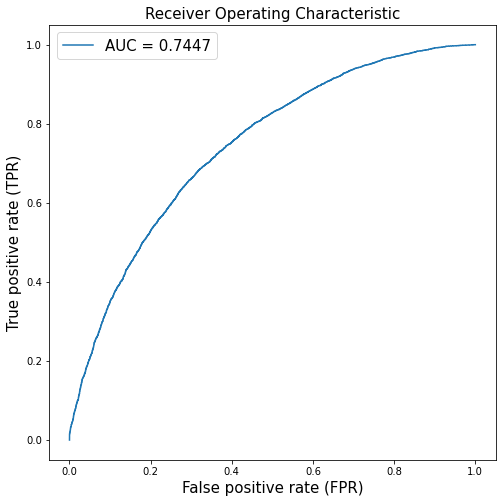

In [466]:
roc_auc = roc_auc_score(y_control, y_pred)

fpr, tpr, thresholds = roc_curve(y_control,lr.predict_proba(X_control).T[1])
roc_auc = roc_auc_score(y_control,lr.predict_proba(X_control).T[1])   
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.legend(fontsize=15)

In [336]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression()

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_teach, y_teach)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

C:\Users\LocalAdministrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 220.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\LocalAdministrator\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\LocalAdministrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1528, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\LocalAdministrator\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1150, in _fit_

	C: 1.0
	class_weight: 'none'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'l2'
	random_state: None
	solver: 'saga'
	tol: 0.001
	verbose: 0
	warm_start: False


In [467]:
lr_opt = LogisticRegression(penalty='l2', dual=False, tol=0.001, 
                        C=1.0, fit_intercept=True, intercept_scaling=1, 
                        class_weight='none', random_state=None, 
                        solver='saga', max_iter=50, multi_class='auto', 
                        verbose=0, warm_start=False, n_jobs=None, 
                        l1_ratio=None)
lr_opt.fit(X_teach, y_teach)
y_pred_opt = lr_opt.predict(X_control)

C:\Users\LocalAdministrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [468]:
from sklearn.metrics import classification_report
classification_report1 = classification_report(y_control, y_pred_opt)
print(classification_report1)

              precision    recall  f1-score   support

           0       0.68      0.67      0.68      6442
           1       0.68      0.69      0.68      6444

    accuracy                           0.68     12886
   macro avg       0.68      0.68      0.68     12886
weighted avg       0.68      0.68      0.68     12886



In [469]:
conf_mat = confusion_matrix(y_control, y_pred_opt).T
print('Confusion matrix:\n{}'.format(conf_mat))

Confusion matrix:
[[4333 1995]
 [2109 4449]]


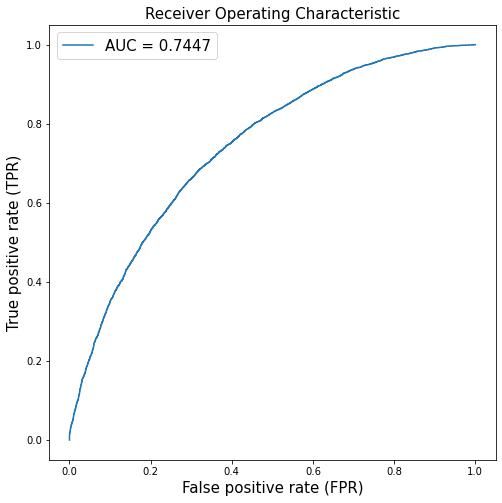

In [470]:
roc_auc = roc_auc_score(y_control, y_pred_opt)

fpr, tpr, thresholds = roc_curve(y_control,lr_opt.predict_proba(X_control).T[1])
roc_auc = roc_auc_score(y_control,lr_opt.predict_proba(X_control).T[1])   
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.title('Receiver Operating Characteristic', fontsize=15)
plt.xlabel('False positive rate (FPR)', fontsize=15)
plt.ylabel('True positive rate (TPR)', fontsize=15)
plt.legend(fontsize=15)

# Вывод

###### Качество построенной модели следует оценивать по метрике f1-score и по confusion matrix, из которой нужно обращать внимание на False negative (2-я строка, 1-й столбец), т.к. это самый плохой случай : модель сказала дефолта не будет, а он будет.
###### Мне удалось достичь f1-score = 0.68

# Final

In [408]:
# если качество нас устраивает, обучаем финальную модель на всех обучающи данных
lr_final = LogisticRegression(penalty='l2', dual=False, tol=0.001, 
                        C=1.0, fit_intercept=True, intercept_scaling=1, 
                        class_weight='none', random_state=None, 
                        solver='saga', max_iter=50, multi_class='auto', 
                        verbose=0, warm_start=False, n_jobs=None, 
                        l1_ratio=None)

# повторим все преобразования с обучающими данными
#Стандартизация непрерывных признаков в train и control датасетах
X_final_num_val = StandardScaler().fit_transform(X[num_cols].values)

#кодирование категориальных признаков в train и control датасетах
X_final_cat_val = OneHotEncoder(sparse = False).fit_transform(X[cat_cols].values)

X_final = np.hstack([X_final_num_val, X[bin_cols].values, X_final_cat_val])
y_final = y

lr_final.fit(X_final, y_final)

C:\Users\LocalAdministrator\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='none', max_iter=50, solver='saga', tol=0.001)

In [409]:
# повторим все преобразования с test_data
#Стандартизация непрерывных признаков в test_data
test_num_val = StandardScaler().fit_transform(test_data[num_cols].values)

#кодирование категориальных признаков в train и control датасетах
test_cat_val = OneHotEncoder(sparse = False).fit_transform(test_data[cat_cols].values)

test = np.hstack([test_num_val, test_data[bin_cols].values, test_cat_val])

predict_submission = lr_final.predict(test)

In [472]:
sample_submission['default'] = predict_submission
#sample_submission.to_csv('submission.csv', index=False)
sample_submission.to_csv(DATA_DIR+'submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0
5,99881,0
6,26630,0
7,79934,0
8,16605,0
9,105449,0


In [ ]:
!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'